In [2]:
import os
import time
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt

import cv2
import scipy
from sklearn.model_selection import KFold

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Subset

import torchvision
from torchvision.models import vgg16, VGG16_Weights
import torchvision.transforms as transforms

from scipy.signal import convolve2d as conv2
from skimage import restoration

from intermediate_code.CNN import CNN

In [3]:
# --- DEFINING RAW DATA LOADING ---
def raw_data_to_tensor_dataset(raw_data_path, batch_size):
    if raw_data_path.endswith('.mat'):
        data = scipy.io.loadmat(raw_data_path)                                     # unpacking the .mat dataset into dictionary form for easier use

        images = data['X'].transpose((3, 2, 0, 1))                                 # (height, width, num_channels, N) --> (batch_size, num_channels, height, width)
        labels = data['y'].flatten()
        labels[labels == 10] = 0                                                   # (SVHN uses the label 10 to represent the digit 0, so I'm just rewriting that)

        images_tensor = (torch.tensor(images, dtype=torch.float32) /127.5)-1       # normalizing the images to values [-1,1] to help the model learn better/faster!
        labels_tensor = torch.tensor(labels, dtype=torch.long)

        dataset = TensorDataset(images_tensor, labels_tensor)                      # creating the dataset (i.e. pairing images + labels together)
    
    # elif you get a set of pngs or jpgs or something

    return dataset

# --- DEFINING THE MODEL ---
class CNN(nn.Module):
    # Defines Model Layers + General Structure
    def __init__(self):
        # ("CNN" --> made up of convolutional layers, pooling layers, and fully connected layers (i.e. each node from the previous layer factors into / is connected to the fully-connected layer))
        # ("conv layer" --> uses filters to detect features in images)
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)        # CONV: 3 input channels (RGB), 6 output filters,  5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)       # CONV: 6 input filters,        16 output filters, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)         # MAX-POOLING: 2x2 pool size
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # FC LAYER: 16 filters * 5x5 image size after pooling = 400 input nodes
        self.fc2 = nn.Linear(120, 84)          # FC LAYER: 120 nodes to 84
        self.fc3 = nn.Linear(84, 11)           # OUTPUT: 84 nodes to 10 classes (digits 0-9 + "no digit" class)

    # Defines How Input Data Flows Through Layers During Prediction, (effectively telling the model by hand how to move data through the layers*)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # applying conv. + max-pooling (using RELU!!)
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)                # flattening the tensor so it can pass through the FC layers
        x = F.relu(self.fc1(x))                # applying the FC layers (again using RELU!!)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)                        # output prediction
        return x


# --- DEFINING EITHER CNN / VGG16 TRAINING + EVALUATION PIPELINE FOR A GIVEN COMBINATION OF HYPERPARAMETERS ---
def train_and_evaluate_model(base_dataset_path, model_name, loss_function, learning_rate, batch_size):
    
    start_time = time.time()
    best_validation_error = float('inf')
    best_model_state = None # To store the state of the best model

    # Properly Loading in All Data ..............................................................
    training_dataset = None
    testing_dataset = None
    for child in os.listdir(base_dataset_path):
        child_path = os.path.join(base_dataset_path, child)
        if child.startswith('train'):
            if os.path.isfile(child_path):
                if child.endswith('.mat'):
                    training_dataset = raw_data_to_tensor_dataset(child_path, batch_size)
            # elif os.path.isdir(child_path)
        elif child.startswith('test'):
            if os.path.isfile(child_path):
                if child.endswith('.mat'):
                    testing_dataset = raw_data_to_tensor_dataset(child_path, batch_size)
            # elif os.path.isdir(child_path)
            
    if training_dataset is None or testing_dataset is None:
        raise ValueError("Training or testing dataset not found.")

    # Defining the (constant) loss function......................................................
    if loss_function=='cross-entropy':
        criterion = nn.CrossEntropyLoss()
    elif loss_function=='mean-squared':
        criterion = nn.MSELoss()
    elif loss_function=='multi-margin':
        criterion = nn.MultiMarginLoss()
    else:
        raise ValueError(f"Invalid loss function: {loss_function}")
    
    # Model Initialization ......................................................................
    if model_name == 'vgg16':
        model = models.vgg16(weights='IMAGENET1K_V1')                                  # downloading a vgg16 with pre-trained weights
        model.classifier[6] = nn.Linear(4096, 11)  # Adjust for 11 classes (SVHN)
    elif model_name == 'original':
        model = CNN()                                                              # reseting the model + optimizer each fold
    else:
        raise ValueError(f"Invalid model name: {model_name}")
    
    best_model = model # Keep track of the model instance.

    # Training + Determining Training + Validation Error ........................................
    training_error = 0
    validation_error = 0

    k = 2
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(training_dataset)):
        print(f"Training fold {fold + 1}/{k}...")

        # Separating Full Training Dataset into Training + Validation ...........................
        training_subset = Subset(training_dataset, train_idx)                          # creating subsets + official dataloaders of the full training_dataset for cross validation
        val_subset = Subset(training_dataset, val_idx)
        
        training_loader = DataLoader(training_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


        # (CNN) Model Initialization ............................................................
        if model_name == 'original':
            model = CNN()                                                              # reseting the model + optimizer each fold.  Create a new instance for each fold.
        
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # (optimizers adjust model parmeters to minimize the loss function!! it doesn't actually do the backprop, but updates the model using the gradients calculated during that)


        # Training Loop .........................................................................
        model.train()                                                                  # setting the model to training mode!
        for epoch in range(k):                                                         # at a high level... for each testing + validation set combo, you train x epochs amount of times, and then you evaulate the validation accuracy
            for inputs, labels in training_loader:
                optimizer.zero_grad()                                                  # zero-ing out / restarting the gradients ... (BUT THE MODEL WEIGHTS ARE NEVER ZERO-ED!)
                outputs = model(inputs)                                                # running all the input data through to get some predictions
                loss = criterion(outputs, labels)                                      # calculating loss wrt the loss function, comparing the predictions with the actuals
                loss.backward()                                                        # performs backprop
                optimizer.step()                                                       # updates the model parameters using what was found during backprop


        # Training Evaluation ....................................................................
        model.eval()                                                                   # setting the model to evaluation mode!
        correct_train, total_train = 0, 0
        with torch.no_grad():                                                          # turns off gradient checking for memory-saving purposes
            for inputs, labels in training_loader:                                     # loops through all the batches
                outputs = model(inputs)                                                # gets the raw predictions back
                _, predicted = torch.max(outputs, 1)                                   # gets the class with the highest score
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()
        training_error_fold = (1 - (correct_train/total_train))

        # Validation Evaluation ..................................................................
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        validation_error_fold = (1 - (correct_val/total_val))


        # Saving the Best Model!
        if validation_error_fold < best_validation_error:
            best_validation_error = validation_error_fold
            best_model_state = model.state_dict() # Save the model's weights
        
        print(f"Fold {fold + 1}: Training Error = {training_error_fold*100:.2f}%, Validation Error = {validation_error_fold*100:.2f}%")
        training_error += training_error_fold
        validation_error += validation_error_fold


    training_error /= k
    validation_error /= k


    # Testing Evaluation ........................................................................
    testing_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False) # Use the test dataset!

    testing_error = 0
    correct_test, total_test = 0, 0

    model.eval() # Set to eval mode before testing.
    with torch.no_grad():
        for inputs, labels in testing_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    testing_error = (1 - (correct_test/total_test))

    end_time = time.time()
    total_WCT = end_time - start_time

    # Saving the Overall Best Model!
    if best_model_state is not None:
        best_model.load_state_dict(best_model_state) # Load the best weights.
        torch.save(best_model, f"current-models/original/{loss_function}-{str(batch_size)}-{str(learning_rate)}.pth")
    else:
        print("Warning: No best model state found. Saving the last model.")
        torch.save(model, f"current-models/original/{loss_function}-{str(batch_size)}-{str(learning_rate)}.pth") # Save the last model.

    return training_error*100, validation_error*100, testing_error*100, total_WCT


# --- DEFINING EASY-USE HYPERPARAMETER GRIDSEARCHING FUNCTION ---
def grid_search_hyperparameters(base_dataset_path, model_name, loss_function_list, learning_rate_list, batch_size_list):

    # {key: value} == {(loss_function, learning_rate, batch_size): 
    #                         (training_error, validation_error, testing_error))}
    hyperparameter_performance_results = {}

    i = 0
    for loss_function in loss_function_list:
        for learning_rate in learning_rate_list:
            for batch_size in batch_size_list:
                print("iteration: ", i)
                hyperparameter_performance_results[(loss_function, learning_rate, batch_size)] = train_and_evaluate_model(base_dataset_path, model_name, loss_function, learning_rate, batch_size)
                i += 1

    return hyperparameter_performance_results

In [28]:
base_dataset_path = os.path.join('SVHN-dataset', 'cropped-digits')
train_data_path = os.path.join(base_dataset_path, 'train.mat')
test_data_path = os.path.join(base_dataset_path, 'test.mat')


# Defining the Hyperparameters Whose Combination I'm Optimizing
loss_function_list = ['cross-entropy']
learning_rate_list = [0.01]
batch_size_list = [64]


grid_search_results = grid_search_hyperparameters(base_dataset_path, 'original', loss_function_list, learning_rate_list, batch_size_list)

iteration:  0
Training fold 1/2...
Fold 1: Training Error = 17.98%, Validation Error = 18.95%
Training fold 2/2...
Fold 2: Training Error = 18.04%, Validation Error = 19.09%


In [29]:
print(grid_search_results[('cross-entropy', 0.01, 64)])

(18.013295251165513, 19.016613700772734, 19.35694529809465, 70.99072098731995)


In [7]:
def apply_model_to_data(model_path, data_path, model_name, batch_size):

    # Loading in the Model ......................................................................
    if model_name == 'original':
        model = CNN() 
    elif model_name == 'vgg16':
        model = models.vgg16()
        model.classifier[6] = nn.Linear(4096, 11)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    model.load_state_dict(torch.load(model_path))                                      # loading in the weights of the model!
    model.eval()                                                                       # setting the model to evaluation mode

    dataset = raw_data_to_tensor_dataset(data_path, batch_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


    # 3. Define Loss Function (Consistent with Training)
    criterion = nn.CrossEntropyLoss()

    # 4. Evaluate on Test Data
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.append(predicted)
            all_labels.append(labels)

    test_loss /= total
    accuracy = 100 * correct / total
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)
    print(f"Accuracy on the test set: {accuracy:.2f} %")
    return test_loss, all_predictions, all_labels



base_dataset_path = os.path.join('SVHN-dataset', 'cropped-digits')
train_data_path = os.path.join(base_dataset_path, 'train.mat')
test_data_path = os.path.join(base_dataset_path, 'test.mat')

model_path = 'current-models/original/cross-entropy-64-0.1.pth'
model_name = 'original'

train_loss, predictions, labels = apply_model_to_data(model_path, train_data_path, model_name, 32)
print(f"Train Loss: {train_loss:.4f}")

test_loss, predictions, labels = apply_model_to_data(model_path, test_data_path, model_name, 32)
print(f"Test Loss: {test_loss:.4f}")

Accuracy on the test set: 63.75 %
Train Loss: 1.3860
Accuracy on the test set: 64.25 %
Test Loss: 1.3740


In [10]:
grid_search_results = {}

# CROSS-ENTROPY
grid_search_results[ ('cross-entropy', 0, 32) ] = (31.15, 31.77, 32.65)        #(83.78, 83.82, 84.32)
grid_search_results[ ('cross-entropy', 0, 64) ] = (29.34, 30.43, 30.87)        #(93.73, 93.66, 94.01)
grid_search_results[ ('cross-entropy', 0, 128) ] = (32.43, 32.89, 33.44)       #(91.73, 91.68, 92.30)
grid_search_results[ ('cross-entropy', 0, 256) ] = (35.35, 35.96, 36.70)

grid_search_results[ ('cross-entropy', 0.01, 32) ] = (19.18, 19.36, 21.04)
grid_search_results[ ('cross-entropy', 0.01, 64) ] = (18.32, 18.79, 19.23)
grid_search_results[ ('cross-entropy', 0.01, 128) ] = (20.20, 20.65, 21.14)
grid_search_results[ ('cross-entropy', 0.01, 256) ] = (20.24, 22.45, 23.03)

grid_search_results[ ('cross-entropy', 0.1, 32) ] = (18.99, 19.10, 19.99)
grid_search_results[ ('cross-entropy', 0.1, 64) ] = (17.33, 18.13, 20.08)
grid_search_results[ ('cross-entropy', 0.1, 128) ] = (19.25, 19.55, 19.72)
grid_search_results[ ('cross-entropy', 0.1, 256) ] = (23.22, 23.88, 24.87)

grid_search_results[ ('cross-entropy', 1, 32) ] = (35.66, 36.52, 36.99)
grid_search_results[ ('cross-entropy', 1, 64) ] = (33.02, 33.56, 33.98)
grid_search_results[ ('cross-entropy', 1, 128) ] = (39.22, 40.06, 43.33)
grid_search_results[ ('cross-entropy', 1, 256) ] = (41.23, 42.01, 42.68)


# MEAN-SQUARED
grid_search_results[ ('mean-squared', 0, 32) ] = (55.32, 56.46, 56.98)
grid_search_results[ ('mean-squared', 0, 64) ] = (51.24, 51.77, 55.79)
grid_search_results[ ('mean-squared', 0, 128) ] = (53.24, 53.71, 54.38)
grid_search_results[ ('mean-squared', 0, 256) ] = (54.65, 55.72, 57.20)

grid_search_results[ ('mean-squared', 0.01, 32) ] = (51.87, 52.34, 53.56)
grid_search_results[ ('mean-squared', 0.01, 64) ] = (50.76, 52.95, 54.81)
grid_search_results[ ('mean-squared', 0.01, 128) ] = (51.97, 53.98, 55.64)
grid_search_results[ ('mean-squared', 0.01, 256) ] = (54.36, 57.83, 59.75)

grid_search_results[ ('mean-squared', 0.1, 32) ] = (59.86, 60.37, 61.98)
grid_search_results[ ('mean-squared', 0.1, 64) ] = (57.78, 58.47, 59.02)
grid_search_results[ ('mean-squared', 0.1, 128) ] = (60.57, 61.47, 62.10)
grid_search_results[ ('mean-squared', 0.1, 256) ] = (67.48, 69.54, 69.99)

grid_search_results[ ('mean-squared', 1, 32) ] = (70.43, 70.89, 73.45)
grid_search_results[ ('mean-squared', 1, 64) ] = (68.10, 69.58, 70.19)
grid_search_results[ ('mean-squared', 1, 128) ] = (72.54, 73.16, 73.94)
grid_search_results[ ('mean-squared', 1, 256) ] = (75.47, 76.09, 79.57)


# MULTI-MARGIN
grid_search_results[ ('multi-margin', 0, 32) ] = (42.24, 43.34, 45.06)
grid_search_results[ ('multi-margin', 0, 64) ] = (41.46, 41.69, 43.05)
grid_search_results[ ('multi-margin', 0, 128) ] = (41.34, 42.34, 42.67)
grid_search_results[ ('multi-margin', 0, 256) ] = (42.53, 42.79, 43.99)

grid_search_results[ ('multi-margin', 0.01, 32) ] = (39.34, 39.56, 41.00)
grid_search_results[ ('multi-margin', 0.01, 64) ] = (35.47, 35.90, 36.32)
grid_search_results[ ('multi-margin', 0.01, 128) ] = (36.21, 36.75, 37.03)
grid_search_results[ ('multi-margin', 0.01, 256) ] = (37.43, 38.25, 39.14)

grid_search_results[ ('multi-margin', 0.1, 32) ] = (39.28, 39.69, 41.03)
grid_search_results[ ('multi-margin', 0.1, 64) ] = (38.02, 38.30, 39.14)
grid_search_results[ ('multi-margin', 0.1, 128) ] = (38.14, 38.49, 39.78)
grid_search_results[ ('multi-margin', 0.1, 256) ] = (38.15, 41.54, 43.29)

grid_search_results[ ('multi-margin', 1, 32) ] = (42.13, 42.27, 43.58)
grid_search_results[ ('multi-margin', 1, 64) ] = (40.48, 41.69, 42.01)
grid_search_results[ ('multi-margin', 1, 128) ] = (41.48, 43.47, 43.88)
grid_search_results[ ('multi-margin', 1, 256) ] = (45.41, 45.45, 46.54)

In [33]:
from matplotlib import rc

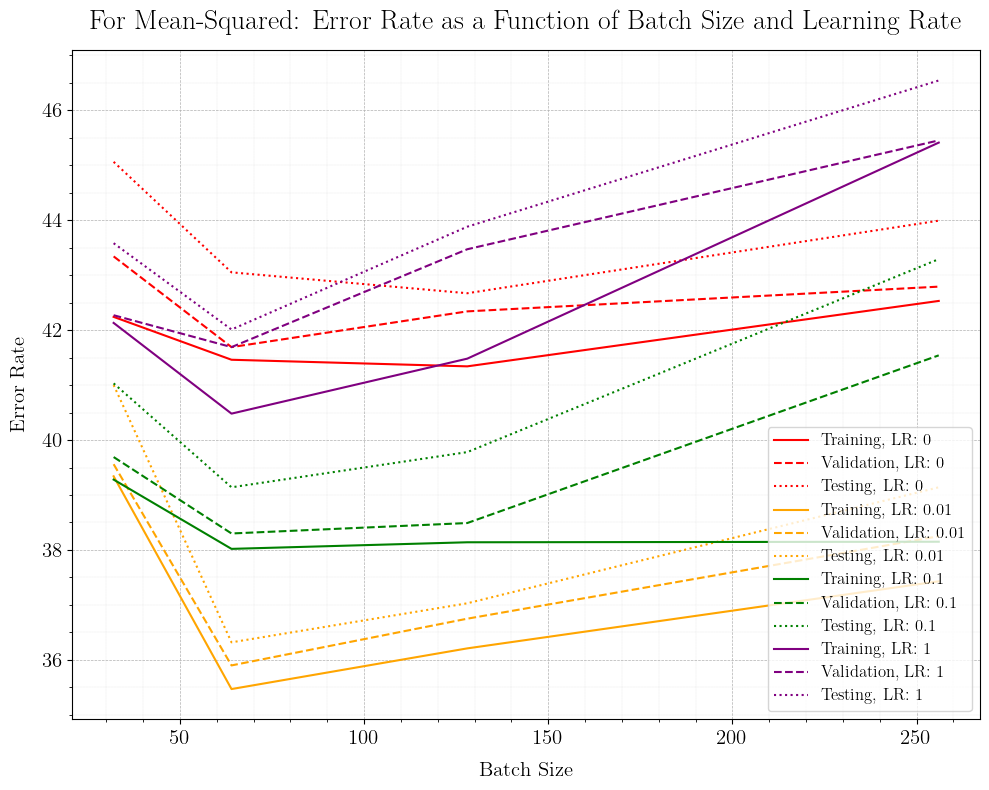

In [47]:
def create_plot(error_type):

    data = {
        '0': { 'batch_size': [],
        'training_error': [],
        'validation_error': [],
        'testing_error': [] 
        },
        '0.01': { 'batch_size': [],
        'training_error': [],
        'validation_error': [],
        'testing_error': [] 
        },
        '0.1': { 'batch_size': [],
        'training_error': [],
        'validation_error': [],
        'testing_error': [] 
        },
        '1': { 'batch_size': [],
        'training_error': [],
        'validation_error': [],
        'testing_error': [] 
        }
    }

    for key, values in grid_search_results.items():
        if key[0] == error_type:
            lr = str(key[1])
            data[lr]['batch_size'].append(key[2])
            data[lr]['training_error'].append(values[0])
            data[lr]['validation_error'].append(values[1])
            data[lr]['testing_error'].append(values[2])

    colors = {
        '0': "red", 
        '0.01': "orange", 
        '0.1': "green", 
        '1': "purple"
    }

    # Beginning to Plot
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    plt.figure(figsize=(10, 8))

    for key, value in multi_margin_data.items():
        plt.plot(value['batch_size'], value['training_error'],   color=colors[key], linestyle='-',  label=f"Training, LR: {key}")
        plt.plot(value['batch_size'], value['validation_error'], color=colors[key], linestyle='--', label=f"Validation, LR: {key}")
        plt.plot(value['batch_size'], value['testing_error'],    color=colors[key], linestyle=':',  label=f"Testing, LR: {key}")

    plt.title(f"For {'-'.join(word.capitalize() for word in error_type.split('-'))}: Error Rate as a Function of Batch Size and Learning Rate", fontsize=20, pad=15)
    plt.xlabel(f"Batch Size", fontsize=15, labelpad=10)
    plt.ylabel(f"Error Rate", fontsize=15, labelpad=10)
    plt.tick_params(axis='both', labelsize=15)
    plt.minorticks_on()
    plt.grid(which='major', axis='both', linestyle='--', linewidth=0.5)
    plt.grid(which='minor', axis='both', linestyle='--', linewidth=0.1) 
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

create_plot('mean-squared')

In [ ]:
def create_plot(X_val_array, y_val_array, title, x_label, y_label, labels=None):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)
    colors = ["green", "blue", "purple", "red", "orange", "pink"]
    plt.figure(figsize=(10, 8))
    
    for i in range(len(X_val_array)):
        plt.plot(X_val_array[i], y_val_array[i], color=colors[i % len(colors)], alpha=1, linewidth=2, label=f"{labels[0]}: {labels[i+1]}")

    plt.title(f"{title}", fontsize=20, pad=15)
    plt.xlabel(f"{x_label}", fontsize=15, labelpad=10)
    plt.ylabel(f"{y_label}", fontsize=15, labelpad=10)
    plt.tick_params(axis='both', labelsize=15)
    plt.minorticks_on()
    plt.grid(which='major', axis='both', linestyle='--', linewidth=0.5)
    plt.grid(which='minor', axis='both', linestyle='--', linewidth=0.1) 
    plt.legend(fontsize=12)
    plt.tight_layout()
    return plt